In [1]:
from datasets import SOCOFingFingers
from FPMLmodule.backbones import ResNet50, MobileNetV2, EfficientNetB2,ResNet101,Xception,InceptionV3
from FPMLmodule.classifiers import ResNetClassifier, DefaultClassifier, AlexNetClassifier, MobileNetClassifier
import FPMLmodule.utils as utils
from FPMLmodule.fpml import FPML 
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from tensorflow.keras.models import Sequential
import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.7.0


In [2]:
# Global Config
seed=9
img_dim = (120, 120, 3)
img_height, img_width, img_channels = img_dim
batch_size = 32

# Dataset configuration

AUTOTUNE = tf.data.AUTOTUNE
split_ratio = [0.7, 0.15, 0.15]
shuffle=True
dsConfig = {
    'batchSize': batch_size, 
    'parallelTune': AUTOTUNE, 
    'split': split_ratio, 
    'inputDim': img_dim, 
    'seed': seed, 
    'shuffle': shuffle
    }
weightsRN50 = "./weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
weightsMNV2 = "./weights/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5"
weightsENB2 = "./weights/efficientnetb2_notop.h5"
weightsRN101 = "./weights/resnet101_weights_tf_dim_ordering_tf_kernels.h5"
weightsXCEP = "./weights/xception_weights_tf_dim_ordering_tf_kernels.h5"
weightsINCEV3 = "./weights/inception_v3_weights_tf_dim_ordering_tf_kernels.h5"

# Model Config
learning_rate = 0.001
epochs_find_best = 10
epochs_best = 100

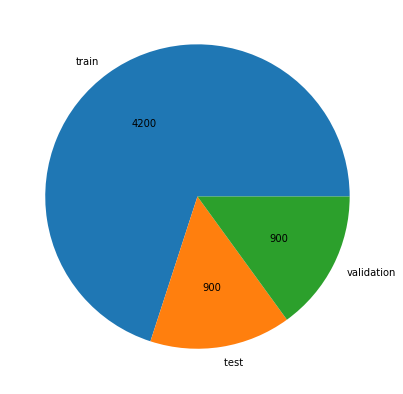

In [3]:
SOCOFingers = SOCOFingFingers(**dsConfig)
fingerDs = SOCOFingers.create()
utils.displayDsSplit(fingerDs)
train_ds, test_ds, val_ds = fingerDs
# Show split by gender


In [4]:
nbClasses = len(SOCOFingers.classNames)
activation = "softmax"

classifiers = {
    "ResNet50" : ResNetClassifier(nbClasses, activation),
    "AlexNet" : AlexNetClassifier(nbClasses, activation),
    "Default" : DefaultClassifier(nbClasses, activation), 
    "MobileNetV2" : MobileNetClassifier(nbClasses, activation)
}

backbones = {
    "ResNet50" : ResNet50(img_dim, weights=weightsRN50, trainable=False),
    "MobileNetV2-pretrained" : MobileNetV2(img_dim, weights=weightsMNV2, trainable=False),
    "MobileNetV2-trainable": MobileNetV2(img_dim, weights=None),
    "ResNet101" : ResNet101(img_dim, weights=weightsRN101, trainable=False),
    "EfficientNetB2" : EfficientNetB2(img_dim, weights=weightsENB2, trainable=False),
    "Xception" : Xception(img_dim, weights=weightsXCEP, trainable=False),
    "InceptionV3" : InceptionV3(img_dim, weights=weightsINCEV3, trainable=False)
    
}

optimizers = {
    "Adam": Adam,
    "Nadam": Nadam,
    "RMSProp": RMSprop
}


In [5]:
hypers = {
    "optimizer": Adam,
    "learningRate": learning_rate,
    "loss": 'CategoricalCrossentropy',
    "metrics": 'accuracy'
}
pretrainedVsFulltrainig = {
    "mobilenetV2-pretrained" : {
        "architecture": {
            "backbone":backbones["MobileNetV2-pretrained"],
            "classfier":classifiers["MobileNetV2"],
            "inputLayer":"", 
            "inputDim": img_dim
        },
        "hyperparameters":hypers
    },
    "MobileNetV2-trainable" : {
        "architecture": {
            "backbone":backbones["MobileNetV2-trainable"],
            "classfier":classifiers["MobileNetV2"],
            "inputLayer":"", 
            "inputDim": img_dim
        },
        "hyperparameters":hypers
    }
}

In [7]:

studies = {
    "resnet50" : {
        "architecture": {
            "backbone":backbones["ResNet50"],
            "classfier":classifiers["ResNet50"],
            "inputLayer":"", 
            "inputDim": img_dim
        },
        "hyperparameters":hypers
    },
    "efficientnetB2": {
        "architecture": {
            "backbone":backbones["EfficientNetB2"],
            "classfier":classifiers["Default"],
            "inputLayer":"", 
            "inputDim": img_dim
        },
        "hyperparameters":hypers
    },
    "resnet101": {
        "architecture": {
            "backbone":backbones["ResNet101"],
            "classfier":classifiers["Default"],
            "inputLayer":"", 
            "inputDim": img_dim
        },
        "hyperparameters":hypers
    },
    "inceptionV3": {
        "architecture": {
            "backbone":backbones["InceptionV3"],
            "classfier":classifiers["Default"],
            "inputLayer":"", 
            "inputDim": img_dim
        },
        "hyperparameters":hypers
    },
    "xception": {
        "architecture": {
            "backbone":backbones["Xception"],
            "classfier":classifiers["Default"],
            "inputLayer":"", 
            "inputDim": img_dim
        },
        "hyperparameters":hypers
    }
}

histories = utils.researchStudies(train_ds, val_ds, studies, 2,1) 



Epoch 1/2
132/132 [==============================] - 193s 1s/step - loss: 2.5115 - accuracy: 0.1290 - val_loss: 2.1434 - val_accuracy: 0.1800
Epoch 2/2
132/132 [==============================] - 173s 1s/step - loss: 2.1558 - accuracy: 0.1786 - val_loss: 2.0021 - val_accuracy: 0.1933


In [8]:
print(utils.getBestStudyFromHistories(histories))

efficientnetB2


91897856/91884032 [==============================] - 18s 0us/step
